Pass 1 Bearing [degrees],Pass 2 Bearing [degrees],Cumulative Offset [m]
56.2646,56.506,4.0655


,KP From,KP To,HOOS Sigma,HOOS 2Sigma,VOOS Sigma,VOOS 2Sigma
Run,,,,,,
1,0.4960,0.5958,0.028,0.055,0.026,0.052
2,0.5960,0.6958,0.035,0.069,0.026,0.052
3,0.6960,0.7958,0.043,0.085,0.028,0.054
4,0.7960,0.8958,0.024,0.047,0.028,0.054
5,0.8960,0.9958,0.026,0.051,0.028,0.056
6,0.9960,1.0958,0.094,0.184,0.019,0.036
7,1.0960,1.1958,0.027,0.054,0.024,0.047
8,1.1960,1.2958,0.041,0.08,0.037,0.072
9,1.2960,1.3958,0.05,0.097,0.034,0.066


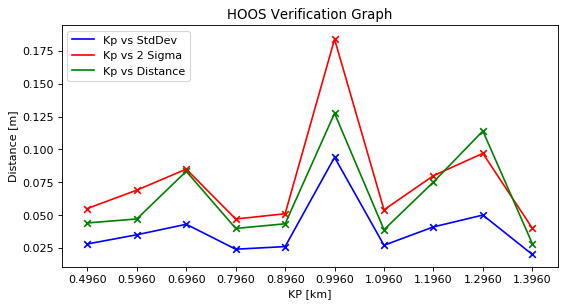

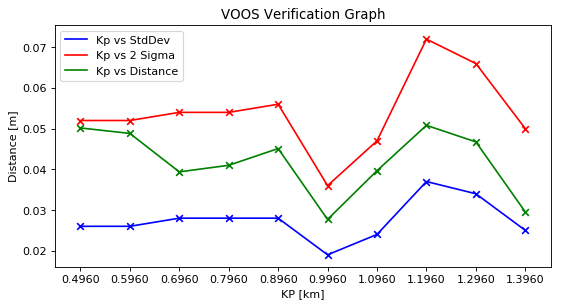

In [1]:
%matplotlib inline
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geo.sphere as sphere
import utm
from scipy.spatial import distance
from IPython.display import display, HTML
from copy import deepcopy

class Record:
    def __init__(self, kp, x, y, z):
        self.kp = kp
        self.x = x
        self.y = y
        self.z = z

class OosStats:
    def __init__(self):
        self.runs = []
        self.kpFroms = []
        self.kpTos = []
        self.hoosSigmas = []
        self.hoos2Sigmas = []
        self.voosSigmas = []
        self.voos2Sigmas = []
        self.hoosDistances = []
        self.voosDistances = []
    
    def calculateStats(self, forwardRuns, backwardRuns):
        hRunDistances = []
        vRunDistances = []
        rate = 1.96
        run = 0
        for i in range(len(forwardRuns)):
            run +=1
            self.runs.append(run)
            forwardRun = forwardRuns[i]
            backwardRun = backwardRuns[i]
            kpFrom = forwardRun[0].kp
            kpTo = forwardRun[len(forwardRun) - 1].kp
            for j in range(len(forwardRun)):
                hDistance =  distance.euclidean([forwardRun[j].x, forwardRun[j].y],[backwardRun[j].x, backwardRun[j].y])
                vDistance = distance.euclidean([forwardRun[j].z], [backwardRun[j].z])
                hRunDistances.append(hDistance)
                vRunDistances.append(vDistance)

            hoosSigma = np.std(np.array(hRunDistances))
            self.hoosSigmas.append(hoosSigma)
            hoos2Sigma = rate * hoosSigma
            self.hoos2Sigmas.append(hoos2Sigma)

            voosSigma = np.std(np.array(vRunDistances))
            self.voosSigmas.append(voosSigma)
            voos2Sigma = rate * voosSigma
            self.voos2Sigmas.append(voos2Sigma)
    
            hoosMean = np.mean(np.array(hRunDistances))
            self.hoosDistances.append(hoosMean)
            voosMean = np.mean(np.array(vRunDistances))
            self.voosDistances.append(voosMean)

            self.kpFroms.append(kpFrom)
            self.kpTos.append(kpTo)

            hRunDistances =[]
            vRunDistances = []

# Utilities -------------------------------------------------------------------
def highlight_cols(val):
    if val > threshold2Sigma:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

# Functions--------------------------------------------------------------------

# Datum rotation
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    x′=xcosθ − ysinθ 
    y′=xsinθ + ycosθ
    """
    originX, originY = origin
    pointX, pointY = point
    resultX = originX + math.cos(angle) * (pointX - originX) - math.sin(angle) * (pointY - originY)
    resultY = originY + math.sin(angle) * (pointX - originX) + math.cos(angle) * (pointY - originY)
    return resultX, resultY

# Get Forward and Backward Runs
def GetForwardBackwardRuns(forwardRecs, backwardRecs, viewingWindow):
    forwardRun = []
    forwardRuns = []
    backwardRun = []
    backwardRuns = []
    index = 0
    kpStart = 0
    kpCached = forwardRecs[0].kp
    isKpFirst = True
    while index < len(forwardRecs):
        indexCached = index
        if isKpFirst:
            kpStart = kpCached
        kp = forwardRecs[index].kp
        surveyDistance = abs(kp - kpStart)
        if round(surveyDistance, 4) < viewingWindow:
            forwardRun.append(forwardRecs[index])
            backwardRun.append(backwardRecs[index])
            index += 1
            isKpFirst = False
            # for the last run we want to add it to the list of runs
            if index < len(forwardRecs):
                continue
        forwardRuns.append(forwardRun)
        backwardRuns.append(backwardRun)
        kpCached = kp
        isKpFirst = True
        forwardRun = []
        backwardRun = []
        # We want to keep the index to reiterate
        if index < len(forwardRecs):
            index = indexCached
    return forwardRuns, backwardRuns
   
# Get linear misclosure
def GetLinearMisClosure(forwardRecs, backwardRecs):
    forwardStart = forwardRecs[0]
    forwardEnd = forwardRecs[len(forwardRecs) - 1]
    forwardStartLatLon = utm.to_latlon(forwardStart.x, forwardStart.y, 50, northern = False)
    forwardEndLatLon =  utm.to_latlon(forwardEnd.x, forwardEnd.y, 50, northern = False)

    forwardStartLonLat =(forwardStartLatLon[1], forwardStartLatLon[0])
    forwardEndLonLat =(forwardEndLatLon[1], forwardEndLatLon[0])

    forwardInitialBearing = sphere.bearing(forwardStartLonLat, forwardEndLonLat)

    backwardStart = backwardRecs[0]
    backwardEnd = backwardRecs[len(backwardRecs) - 1]
    backwardStartLatLon = utm.to_latlon(backwardStart.x, backwardStart.y, 50, northern = False)
    backwardEndLatLon =  utm.to_latlon(backwardEnd.x,backwardEnd.y, 50, northern = False)

    backwardStartLonLat =(backwardStartLatLon[1], backwardStartLatLon[0])
    backwardEndLonLat =(backwardEndLatLon[1], backwardEndLatLon[0])

    backwardInitialBearing = sphere.bearing(backwardStartLonLat, backwardEndLonLat)

    offset =  distance.euclidean([forwardEnd.x, forwardEnd.y, forwardEnd.z],
                                                   [backwardEnd.x, backwardEnd.y, backwardEnd.z])
    return forwardInitialBearing, backwardInitialBearing, offset

# Apply Block Shift adjustment
def ApplyBlockShiftAdjustment(forwardRuns, backwardRuns):
    deltaX = 0
    deltaY = 0
    #deltaZ = 0
    for i in range(1, len(backwardRuns)):
        forwardRun = forwardRuns[i]
        backwardRun = backwardRuns[i]
        deltaX = backwardRun[0].x - forwardRun[0].x
        deltaY = backwardRun[0].y - forwardRun[0].y
        #deltaZ = backwardRun[0].z - forwardRun[0].z
        for j in range(len(backwardRun)):
            backwardRun[j].x = backwardRun[j].x - deltaX
            backwardRun[j].y = backwardRun[j].y - deltaY
            #backwardRun[j].z = backwardRun[j].z - deltaZ

# Apply Rotation to backward run
def ApplyRotationAdjustment(backRuns, forwardBearing, backwardBearing):
    origin = (backRuns[0][0].x, backRuns[0][0].y)
    rotation = math.radians(backwardBearing - forwardBearing)
    for i in range(len(backRuns)):
        backwardRun = backRuns[i]
        for j in range (len(backwardRun)):
            point = (backwardRun[j].x, backwardRun[j].y)
            rotatedPoint = rotate(origin, point,  rotation)
            backwardRun[j].x , backwardRun[j].y = rotatedPoint


def ExportToCsv(backRuns, backFileName):
    name , ext = os.path.splitext(backFileName)
    fileName = name + "_Adjusted" + ext
    backwardRecs = []
    for i in range (len(backRuns)):
        backwardRun = backRuns[i]
        for j in range(len(backwardRun)):
            kp = backwardRun[j].kp
            x = backwardRun[j].x
            y = backwardRun[j].y
            z = backwardRun[j].z
            rec = Record(kp, x, y, z)
            backwardRecs.append(rec)
    with open(fileName, 'w') as fs:
        for rec in backwardRecs[:-1]:
            line = "{0:.4f},{1:.4f},{2:.4f},{3:.4f} \n".format(rec.kp, rec.x, rec.y, rec.z)
            fs.write(line)
         # To prevent adding new blank line after the last record
        rec = backwardRecs[-1]
        line = "{0:.4f},{1:.4f},{2:.4f},{3:.4f}".format(rec.kp, rec.x, rec.y, rec.z)
        fs.write(line)

# Start the process------------------------------------------------------------
# Constants
viewingWindow = 0.1
threshold2Sigma = 0.15
forwardFileName= "OOS_Woodside_Run1_rotated.txt"
backwardFileName = "OOS_Woodside_Run2_rotated.txt"

forwardRecords= []
backwardRecords = []

if os.path.isfile(forwardFileName):
    with open(forwardFileName, 'r') as fs1:
        for line in fs1:
            kp, x, y, d = line.split(',')
            record = Record(float(kp), float(x), float(y), float(d))
            forwardRecords.append(record)
else:
    print("{0} does not exist".format(forwardFileName))
    sys.exit(1)

if os.path.isfile(backwardFileName):
    with open(backwardFileName, "r") as fs2:
        for line in fs2:
            kp, x, y, d = line.split(',')
            record = Record(float(kp), float(x), float(y), float(d))
            backwardRecords.append(record)
else:
    print("{0} does not exist".format(backwardFileName))
    sys.exit(1)

forwardInitialBearing, backwardInitialBearing, cumulativeOffset = GetLinearMisClosure(forwardRecords, backwardRecords)
forwardRuns, backwardRuns = GetForwardBackwardRuns(deepcopy(forwardRecords), deepcopy(backwardRecords), viewingWindow)
ApplyBlockShiftAdjustment(forwardRuns, backwardRuns)
oosStats = OosStats()
oosStats.calculateStats(forwardRuns, backwardRuns)

if any(h2Sigma > threshold2Sigma for h2Sigma in oosStats.hoos2Sigmas) or any(v2Sigma > threshold2Sigma for v2Sigma in oosStats.voos2Sigmas):
    forwardRuns = []
    backwardRuns = []
    forwardRuns, backwardRuns = GetForwardBackwardRuns(deepcopy(forwardRecords), deepcopy(backwardRecords), viewingWindow)
    ApplyRotationAdjustment(backwardRuns, forwardInitialBearing, backwardInitialBearing )
    ApplyBlockShiftAdjustment(forwardRuns, backwardRuns)
    oosStats = OosStats()
    oosStats.calculateStats(forwardRuns, backwardRuns)

ExportToCsv(backwardRuns, backwardFileName)

runs = oosStats.runs
kpFroms = oosStats.kpFroms
kpTos = oosStats.kpTos
hoosSigmas = oosStats.hoosSigmas
hoos2Sigmas = oosStats.hoos2Sigmas
voosSigmas = oosStats.voosSigmas
voos2Sigmas = oosStats.voos2Sigmas
hoosDistances = oosStats.hoosDistances
voosDistances = oosStats.voosDistances

# Create Reports ---------------------------------------------------------------  
d = {'Forward Bearing': round(forwardInitialBearing, 4), 
     'Backward Bearing': round(backwardInitialBearing, 4),
     'Distance': round(cumulativeOffset, 4)}
html = "<b> Linear Misclosure</b>"
html += """<table border="1">
<tr><th>Pass 1 Bearing [degrees]</th><th>Pass 2 Bearing [degrees] </th><th>Cumulative Offset [m]</th></tr>"""
html += "<tr><td>{}</td>".format(d['Forward Bearing'])
html += "<td>{}</td>".format(d['Backward Bearing'])
html += "<td>{}</td>".format(d['Distance'])
html += "</tr></table>"
html +=  "<small><small> Bearings are relative to True North </small></small>"
display(HTML(html))

# OOS Verification
d = {'Run' : pd.Series([run for run in runs]),
     'KP From' : pd.Series(["{0:.4f}".format(kpFrom) for kpFrom in kpFroms]),
     'KP To' : pd.Series([round(kpTo, 4) for kpTo in kpTos]),
     'HOOS Sigma' : pd.Series([round(hoosSigma, 3) for hoosSigma in hoosSigmas]),
     'HOOS 2Sigma' : pd.Series([round(hoos2Sigma, 3) for hoos2Sigma in hoos2Sigmas]),
     'VOOS Sigma' : pd.Series([round(voosSigma, 3) for voosSigma in voosSigmas]),
     'VOOS 2Sigma' : pd.Series([round(voos2Sigma, 3) for voos2Sigma in voos2Sigmas])
    }
  
df = pd.DataFrame(d)

kPSeries = df.iloc[:, 1].values
hoosSigmaSeries = df.iloc[:,3].values
hoos2SigmaSeries = df.iloc[:,4].values
voosSigmaSeries = df.iloc[:,5].values
voos2SigmaSeries = df.iloc[:,6].values
df.set_index('Run', inplace=True)

display(HTML("<br/><b> OOS Verification</b>"))
display(df.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['HOOS 2Sigma', 'VOOS 2Sigma']]))
#print(df)

# Plot------------------------------------------------------------------------
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 80
#plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

# plot Hoos -------------------------------------------------------------------
plt.plot(kPSeries, hoosSigmaSeries, color = 'blue', label ='Kp vs StdDev')
plt.scatter(kPSeries, hoosSigmaSeries, color = 'blue', marker='x')

plt.plot(kPSeries, hoos2SigmaSeries, color = 'red', label ='Kp vs 2 Sigma')
plt.scatter(kPSeries, hoos2SigmaSeries, color = 'red', marker='x')

plt.plot(kPSeries, hoosDistances, color = 'green', label ='Kp vs Distance')
plt.scatter(kPSeries, hoosDistances, color = 'green', marker='x')

plt.title('HOOS Verification Graph')
plt.xlabel('KP [km]')
plt.ylabel('Distance [m]')
plt.legend(loc='upper left')
plt.show()

# plot Voos -------------------------------------------------------------------
plt.plot(kPSeries, voosSigmaSeries, color = 'blue', label ='Kp vs StdDev')
plt.scatter(kPSeries,voosSigmaSeries, color = 'blue', marker='x')

plt.plot(kPSeries, voos2SigmaSeries, color = 'red', label ='Kp vs 2 Sigma')
plt.scatter(kPSeries, voos2SigmaSeries, color = 'red', marker='x')

plt.plot(kPSeries, voosDistances, color = 'green', label ='Kp vs Distance')
plt.scatter(kPSeries, voosDistances, color = 'green', marker='x')

plt.title('VOOS Verification Graph')
plt.xlabel('KP [km]')
plt.ylabel('Distance [m]')
plt.legend(loc='upper left')
plt.show()



<div style= "float: left">
<hr>
Party Chief
</div>
<div style= "float: right">
<hr>
Client Representative
</div>